### Setting and Import

In [1]:
!pip install -q -U tensorflow==2.15.1
!pip install -q -U keras_cv
# !pip show tensorflow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/My Drive/Miru_DreamBooth

/content/drive/My Drive/Miru_DreamBooth


In [4]:
import keras_cv
import tensorflow as tf
from utils import *
from constants import *

Using TensorFlow backend


In [5]:
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Found GPU:", gpu)
        strategy = tf.distribute.MirroredStrategy(devices=None)
    else:
        print("GPU not found.")
        strategy = tf.distribute.get_strategy()
except RuntimeError as e:
    print(e)

print("REPLICAS:", strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.AUTOTUNE

Found GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
REPLICAS: 1


## Prompt and Model

In [6]:
# prompt with unique_id
prompt = f"a photo of {UNIQUE_ID} {CLASS_LABEL} by the sea"
print(prompt)

a photo of miru cat by the sea


In [1]:
# Initialize Stable Diffusion model
dreambooth_model = keras_cv.models.StableDiffusion(img_width=RESOLUTION, img_height=RESOLUTION, jit_compile=True)

**prompt**: A text description that guides the model to generate images with specific content.

**batch_size**: Specifies the number of images to be generated.

**num_steps**: Specifies the number of optimization steps to be performed during the generation process. The model attempts to improve the image at each step to better match the prompt. Increasing num_steps can enhance image quality but will also increase the generation time.

**unconditional_guidance_scale (UGS)**: Adjusts the degree of reliance on the prompt during image generation. A higher UGS value means that the generated images will more closely follow the prompt's instructions, usually at the expense of lower image quality, while a lower value allows the model more freedom to interpret the prompt.

## Model 1

learning_rate = 1e-6, max_train_steps = 600

loss of final epoch: 0.1269

In [ ]:
# learning_rate = 1e-6, max_train_steps = 600
# load weights
ckpt_path = f"{PATH}/weights/weights_1e-06_600.h5"
dreambooth_model.diffusion_model.load_weights(ckpt_path)

3439090152/3439090152 [==============================] - 13s 0us/step


30/30 [==============================] - 7s 225ms/step


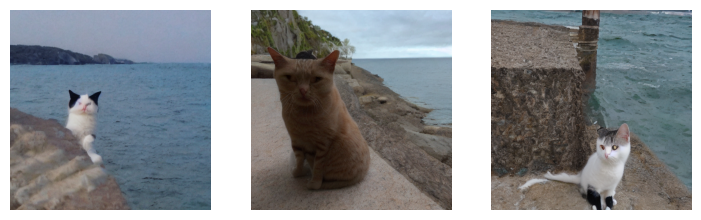

30/30 [==============================] - 7s 225ms/step


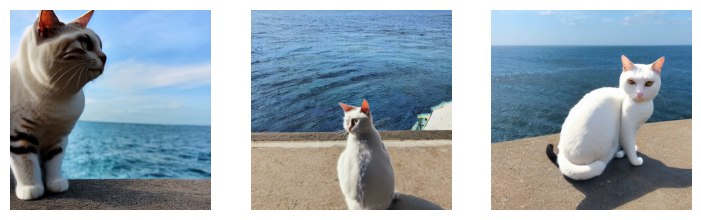

50/50 [==============================] - 11s 225ms/step


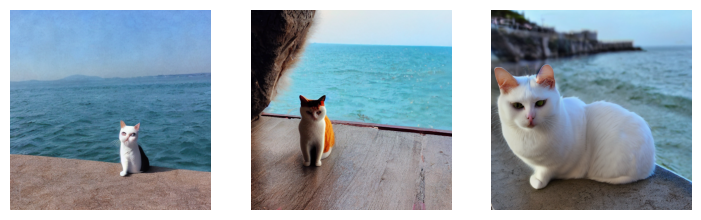

In [ ]:
# set batch_size = 3, generate 3 images
num_img_gen = 3
# set num_steps and unconditional_guidance_scale pairs
steps_ugs_pairs = [(30, 6), (30, 12), (50, 12)]
# generate images sequentially according to steps_ugs_pairs
for steps, ugs in steps_ugs_pairs:
    images = dreambooth_model.text_to_image(prompt, batch_size=num_img_gen, num_steps=steps, unconditional_guidance_scale=ugs)
    plot_images(images)

In the above image generation, the arrangement of images in each row is according to the settings of **num_steps** and **unconditional_guidance_scale** as follows: **(30, 6), (30, 12), (50, 12)**. 

Based on the definition of these parameters, it is expected that increasing **num_steps** can improve image quality, while increasing **UGS** can enhance the dependency on the prompt. Since the instance image is a white cat, the goal is to increase both the fidelity of the instance image (converting from a class image to a white cat) and the image quality.

## Model 2

learning_rate = 1e-6, max_train_steps = 900

loss of final epoch: 0.1128

In [ ]:
# learning_rate = 1e-6, max_train_steps = 900
ckpt_path = f"{PATH}/weights/weights_1e-06_900.h5"
dreambooth_model.diffusion_model.load_weights(ckpt_path)

30/30 [==============================] - 7s 223ms/step


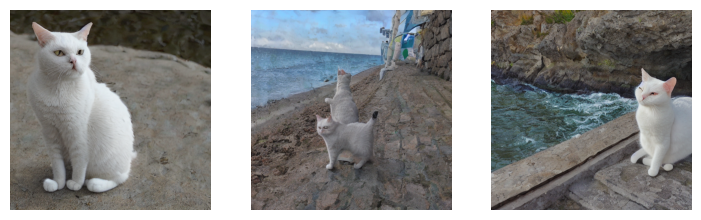

30/30 [==============================] - 7s 225ms/step


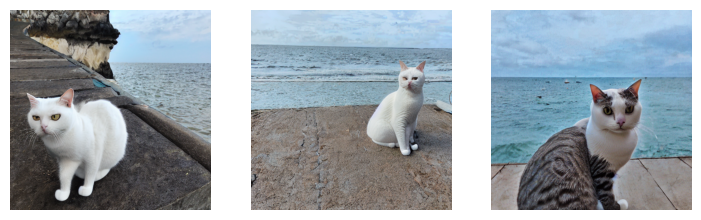

50/50 [==============================] - 11s 224ms/step


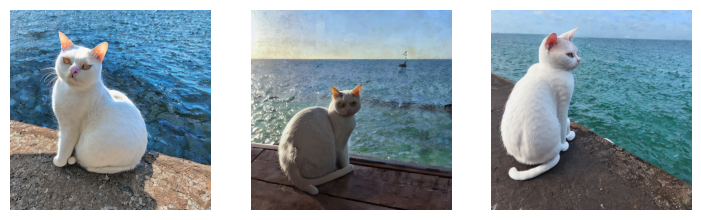

In [ ]:
# images for each row with (steps, gus) set to (30, 6), (30, 12), (50, 12) sequentially
for steps, ugs in steps_ugs_pairs:
    images = dreambooth_model.text_to_image(prompt, batch_size=num_img_gen, num_steps=steps, unconditional_guidance_scale=ugs)
    plot_images(images)

Compared to model 1 trained with steps=600, **model 2** trained with steps=900 shows a noticeable improvement in instance image fidelity.

## Model 3

learning_rate = 3e-6, max_train_steps = 600

loss of final epoch: 0.1030

In [ ]:
# learning_rate = 3e-6, max_train_steps = 600
ckpt_path = f"{PATH}/weights/weights_3e-06_600.h5"
dreambooth_model.diffusion_model.load_weights(ckpt_path)

30/30 [==============================] - 7s 223ms/step


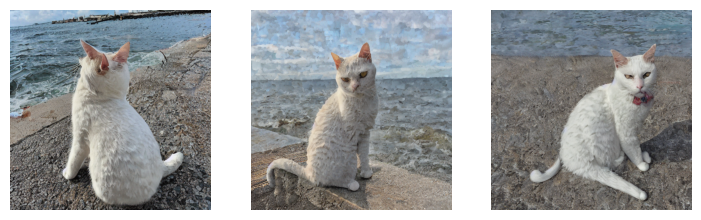

30/30 [==============================] - 7s 224ms/step


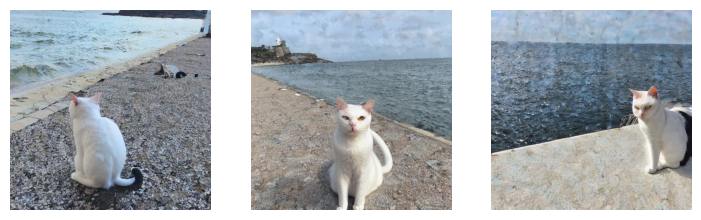

50/50 [==============================] - 11s 224ms/step


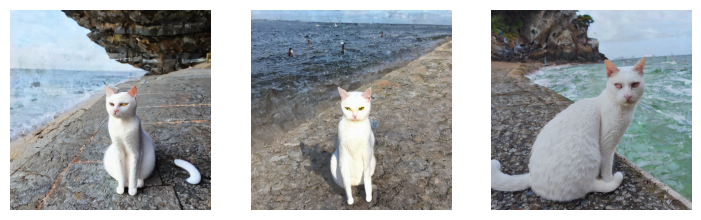

In [ ]:
# images for each row with (steps, gus) set to (30, 6), (30, 12), (50, 12) sequentially
for steps, ugs in steps_ugs_pairs:
    images = dreambooth_model.text_to_image(prompt, batch_size=num_img_gen, num_steps=steps, unconditional_guidance_scale=ugs)
    plot_images(images)

During the training process, it was observed that using a learning rate of 3e-6 is more appropriate for this task than 1e-6. Compared to models 1 and 2, **model 3** learns the instance image better, with a noticeable increase in the proportion of the white cat. The images generated are consistent with the results obtained during the training process.

## Model 4

learning_rate = 3e-6, max_train_steps = 900

loss of final epoch: 0.0894

In [8]:
# learning_rate = 3e-6, max_train_steps = 900
ckpt_path = f"{PATH}/weights/weights_3e-06_900.h5"
dreambooth_model.diffusion_model.load_weights(ckpt_path)

30/30 [==============================] - 7s 222ms/step


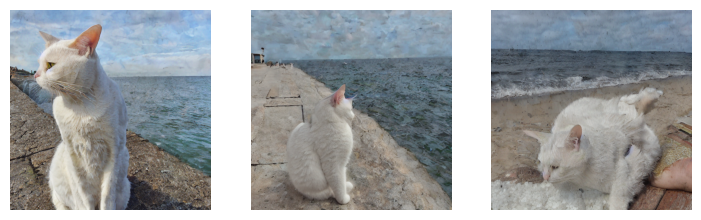

30/30 [==============================] - 7s 223ms/step


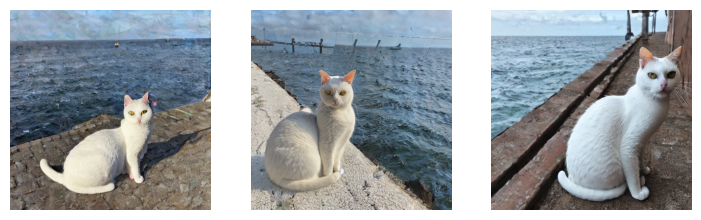

50/50 [==============================] - 11s 223ms/step


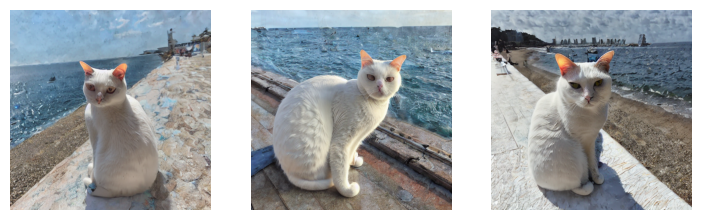

In [ ]:
# images for each row with (steps, gus) set to (30, 6), (30, 12), (50, 12) sequentially
for steps, ugs in steps_ugs_pairs:
    images = dreambooth_model.text_to_image(prompt, batch_size=num_img_gen, num_steps=steps, unconditional_guidance_scale=ugs)
    plot_images(images)

Compared to model 3, **model 4** with max_train_steps of 900 shows a slight improvement, making it the best model obtained at this stage. Using different settings for steps and ugs still maintains a certain fidelity of the instance image.

30/30 [==============================] - 7s 224ms/step


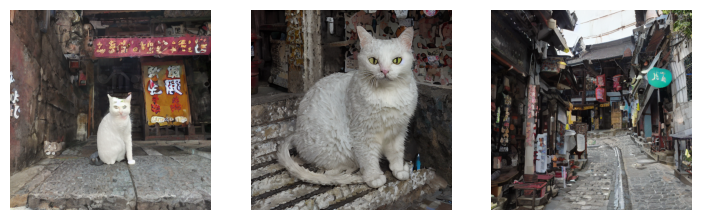

30/30 [==============================] - 7s 223ms/step


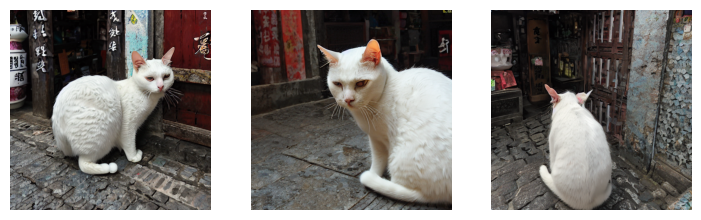

50/50 [==============================] - 11s 223ms/step


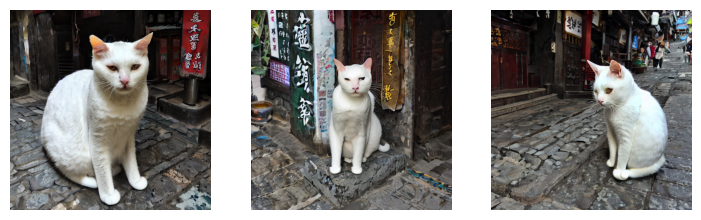

In [ ]:
# new prompt: "a photo of miru cat in Juifen"
prompt = f"a photo of {UNIQUE_ID} {CLASS_LABEL} in Jiufen"

# images for each row with (steps, gus) set to (30, 6), (30, 12), (50, 12) sequentially
for steps, ugs in steps_ugs_pairs:
    images = dreambooth_model.text_to_image(prompt, batch_size=num_img_gen, num_steps=steps, unconditional_guidance_scale=ugs)
    plot_images(images)

Try generating images using a new prompt for a different scene.

In [2]:
# generate more images from model 4
save_folder = f'{PATH}/generated_by_3e-06_900'
generate_and_save_images(save_folder, dreambooth_model, prompt, 10, 1, 50, 12)


## Brief Summary

| Model   | Learning Rate    | Max Train Steps | Loss of Final Epoch |
|---------|------------------|-----------------|---------------------|
| Model 1 | 1e-6  | 600             | 0.1269              |
| Model 2 | 1e-6  | 900             | 0.1128              |
| Model 3 | 3e-6  | 600             | 0.1030              |
| Model 4 | 3e-6  | 900             | 0.0894              |

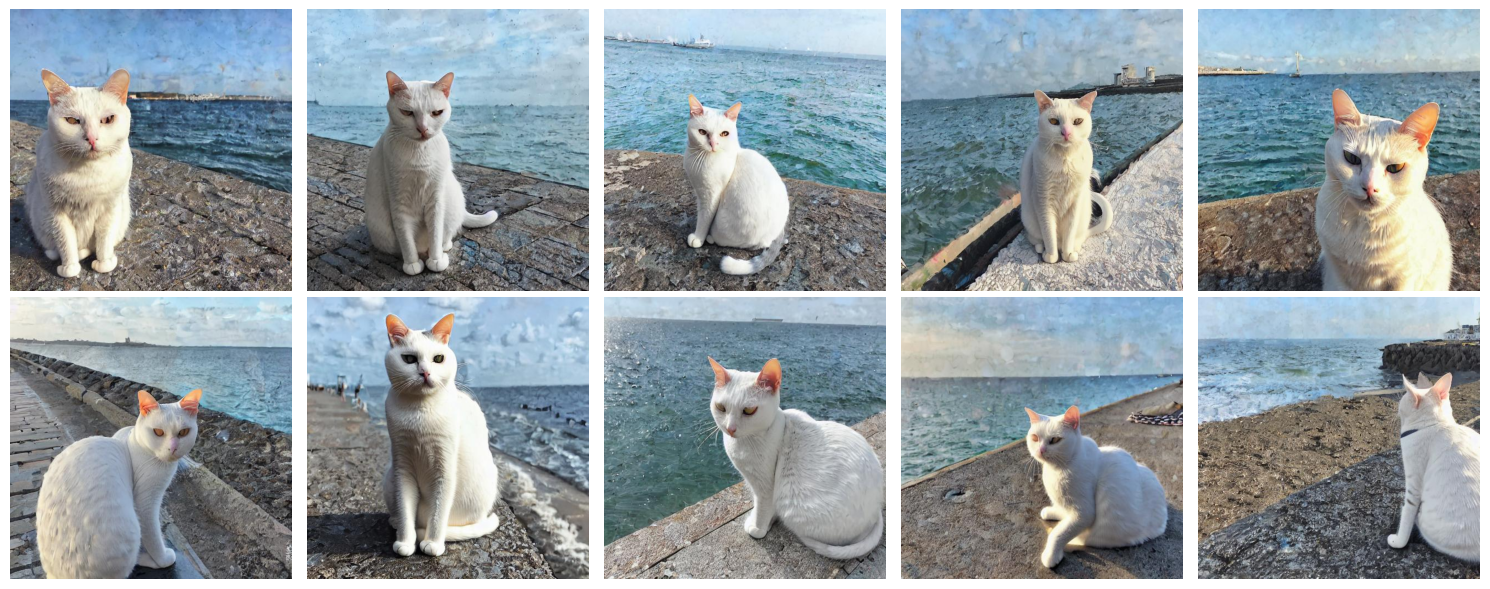

In [7]:
# display the generated images from model 4
images_3e_06_900 = list(paths.list_images(save_folder))
plot_images(load_images(images_3e_06_900[:10]))

For the model and dataset of this task, using a **learning rate of 3e-6** and **max_train_steps of 900** results in a better model. 

After experimenting with different combinations of num_steps and unconditional_guidance_scale values, **steps, ugs = 50, 12** is able to generate images that are not overfitted and achieve a suitable balance between instance image fidelity and image quality.

Subsequently, attempting more precise tuning and adjustments to additional parameters, or fine-tuning to the text editor, all have a high probability of improving the overall model to better suit this task.